##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This notebook contains code focused on analysing features for the final model.
**This is only for exploration.** See `features.py` for functionality related to extracting features for model implementation.

First, read the CSV datafiles (Train and Test).

In [493]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pronouncing as pnc

train_data = pd.read_csv("../datasets/Train.csv", sep=',')
test_data = pd.read_csv("../datasets/Test.csv", sep=',')

### Extracting the individual words

In [494]:

tweets = train_data[['text']].values[:, 0]
sentiments_text = train_data[['sentiment']].values[:, 0]

# takes in a tweet and removes non alpha-numeric symbols
def moderate_symbols(tweet):
    new_tweet = re.sub(r"-+", " ", tweet) # add spaces instead of - characters (they combine words without spaces)
    new_tweet = re.sub(r'\'', "", new_tweet) # remove apostrophes (without spacing)
    new_tweet = re.sub(r'\W', " ", new_tweet) # remove non-alphanumeric symbols (with spacing)
    new_tweet = re.sub(r" +", " ", new_tweet) # condense repeated spaces
    new_tweet = re.sub(r"^ || $", "", new_tweet) # remove the space at the start/end
    return new_tweet


# split by spaces first (removing extraneous punctuation)
tweet_word_lists = [moderate_symbols(x).split(" ") for x in tweets];

# print the head of both lists just to check that it worked
print(tweets[:10])
print(tweet_word_lists[:10])
print(sentiments_text[:20])

[' doctors hit campaign trail as race to medical council elections heats up https://t.co/iifdwb9v0w #homeopathy'
 ' is anybody going to the radio station tomorrow to see shawn? me and my friend may go but we would like to make new friends/meet there (:\t'
 " i just found out naruto didn't become the 5th hokage....\t"
 ' "prince george reservist who died saturday just wanted to help people, his father tells @cbcnews http://t.co/riauzrjgre"\t'
 ' season in the sun versi nirvana rancak gak..slow rockkk...\t'
 " if i didnt have you i'd never see the sun. #mtvstars lady gaga\t"
 ' this is cute. #thisisus @nbcthisisus https://t.co/ndxqyl4gjk'
 ' today is the international day for the elimination of violence against women #orangetheworld #unitednations #unodc‚ä¶ https://t.co/uyqctttufj'
 ' "in his first game back since april 14, david wright went 2-for-5 with a hr, bb and three r on monday. he also made two errors at 3b."\t'
 ' josh hamilton flies out to center... we are going to the bottom o

### Generating Plots for comparison

Different plots will be used to compare how features differ over the sentiments extracted from the tweets.


In [495]:
# Create histograms to compare the distributions across the sentiments
def compare_histograms(numeric_data, label = "", use_bins = True, separate=False):
    COLOURS = ["blue", "red", "green", "purple"]
    index = 0

    # set the bins of the histograms
    bins = None
    if use_bins: bins = range(min(numeric_data), 1 + max(numeric_data))

    if not separate:
        f, axes = plt.subplots(1, 4)
        f.set_size_inches([15, 5])

        # set the labels
        f.supxlabel(label)
        f.supylabel("Relative Frequency")
        f.suptitle(f'Comparing "{label}" across the different sentiments')

        # display the plots
        axes[index].hist(numeric_data, 
            density = True, color = COLOURS[index], bins = bins)
        if use_bins: axes[index].set_ylim([0, 1.2])
        axes[index].set_title("All Sentiments")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_numeric_data = numeric_data[sentiments_text == s]
            axes[index].hist(sub_numeric_data,
                density = True, color = COLOURS[index], bins = bins)
            if use_bins: axes[index].set_ylim([0, 1.2])
            axes[index].set_title(f'{s.upper()} Sentiment')
    else:
        plt.figure(figsize=(15, 5))
        plt.hist(numeric_data,
                density = True, color = COLOURS[index], bins = bins)
        plt.title("All Sentiments")
        plt.xlabel(label)
        plt.ylabel("Relative Frequency")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_numeric_data = numeric_data[sentiments_text == s]
            plt.figure(figsize=(15, 5))
            plt.hist(sub_numeric_data,
                density = True, color = COLOURS[index], bins = bins) 
            plt.title(f'{s.upper()} Sentiment')
            plt.xlabel(label)
            plt.ylabel("Relative Frequency")

# Create bar graph to compare the distributions of discrete features across the sentiments
def compare_bar_graphs(dict_data, label = "", separate = False):
    COLOURS = ["blue", "red", "green", "purple"]
    index = 0

    # sum the count dictionary (occurrences of the keys)
    dict_sums = dict()
    for (key, arr) in dict_data.items():
        dict_sums[key] = sum(arr)

    # sort the names and values of the dict sums in decreasing order
    def sorted_values_names(dict_sums):
        values = list(dict_sums.values())
        names = list(dict_sums.keys())
        zipped = sorted(zip(values, names), reverse=True)
        values = [z[0] for z in zipped]
        names = [z[1] for z in zipped]
        return (values, names)

    values, names = sorted_values_names(dict_sums)

    # display the plots
    if not separate:
        f, axes = plt.subplots(1, 4)
        f.set_size_inches([15, 5])

        # set the labels
        f.supxlabel(label)
        f.supylabel("Frequency")
        f.suptitle(f'Comparing "{label}" across the different sentiments')

        # plot all sentiments
        axes[index].bar(range(len(dict_sums)), values, 
            color = COLOURS[index], tick_label = names)
        axes[index].set_title("All Sentiments")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_dict_sums = dict()
            for (key, arr) in dict_data.items():
                sub_dict_sums[key] = sum(arr[sentiments_text == s])
            values, names = sorted_values_names(sub_dict_sums)
            axes[index].bar(range(len(sub_dict_sums)), values, 
                color = COLOURS[index], tick_label = names)      
            axes[index].set_title(f'{s.upper()} Sentiment')
    else:
        plt.figure(figsize=(15, 5))
        plt.bar(range(len(dict_sums)), values, 
            color = COLOURS[index], tick_label = names)
        plt.title("All Sentiments")
        plt.xlabel(label)
        plt.ylabel("Frequency")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_dict_sums = dict()
            for (key, arr) in dict_data.items():
                sub_dict_sums[key] = sum(arr[sentiments_text == s])
            values, names = sorted_values_names(sub_dict_sums)
            plt.figure(figsize=(15, 5))
            plt.bar(range(len(sub_dict_sums)), values, 
                color = COLOURS[index], tick_label = names)      
            plt.title(f'{s.upper()} Sentiment')
            plt.xlabel(label)
            plt.ylabel("Frequency")


### Length

Something as simple as the character length of the tweets may provide insight into their sentiment.

In [ ]:
# TODO: This

### Word Length Distribution

This could be average word length, or a list of the lengths of words in the tweet.

In [ ]:
# TODO: this

### Character Frequencies

There may be information to gain from the occurrences of different characters in the tweets.

['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¢', '£', '¥', '§', '¨', '©', 'ª', '¬', '®', '°', '±', '´', 'µ', '¶', '·', 'º', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü', 'ÿ', 'ƒ', 'π', 'ω', '–', '—', '‚', '„', '†', '•', '‰', '™', '∂', '∏', '∑', '√', '∞', '∫', '≠', '≤', '≥', '\uf8ff']
[ 8.  7.  2.  5.  6.  5.  0.  9. 10.  3.]


C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 63743 (\uf8ff) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


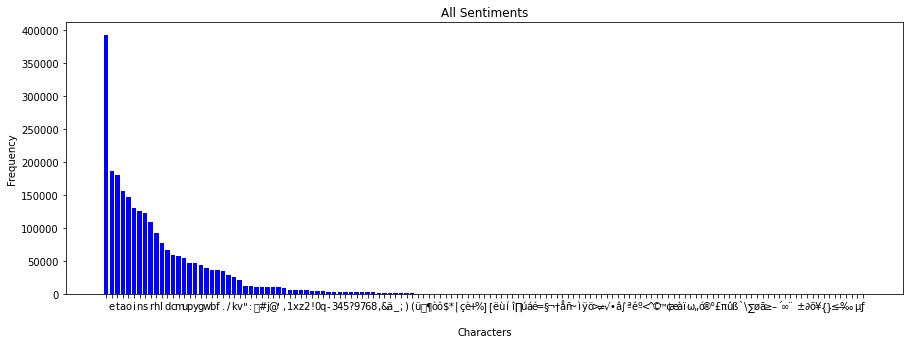

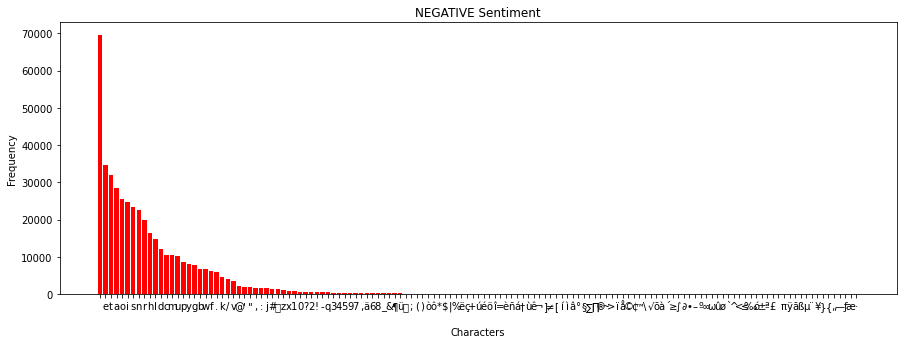

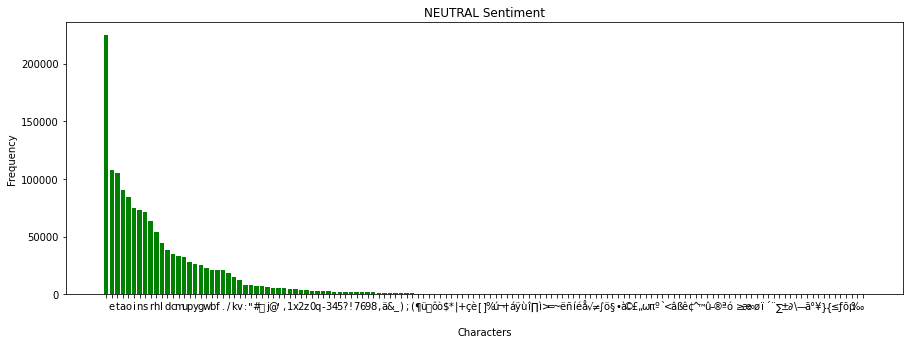

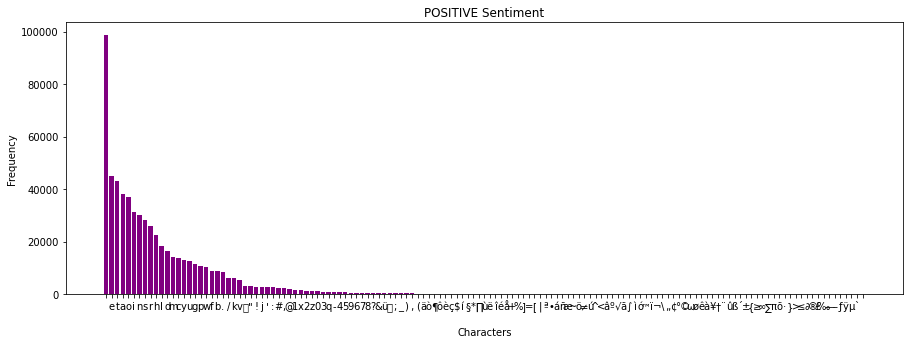

In [496]:
# define a dictionary of arrays of counts per tweet per character
def zero_arr(): return np.zeros((len(tweets)))
dict_character_counts = defaultdict(zero_arr)

# create the set of possible characters
characters = set()

# iterate through the tweets
for i, t in enumerate(tweets):
    characters = characters.union(t)

    # iterate through the chars in t and add to their counts
    for c in t: dict_character_counts[c][i] += 1

characters = sorted(characters)

print(characters)
print(dict_character_counts['a'][:10])

compare_bar_graphs(dict_character_counts, label = "Characters", separate=True)

### Most Biased Words

Most common words with the most obvious biases compiled together.
This may, for example, present in the form of a common cuss word.

In [ ]:
# TODO: this

### TF-IDF
The TF-IDF will identify the most important words in the tweet relative to the other tweets (helps prune out "the").

In [497]:
tfidf_vectorizer = TfidfVectorizer()

#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
tweets_tfidf = tfidf_vectorizer.fit_transform(tweets)

print(tweets_tfidf[1])

  (0, 37883)	0.18565385954834512
  (0, 24659)	0.2500345232367134
  (0, 15226)	0.25639046572035723
  (0, 26660)	0.17561152736960378
  (0, 23985)	0.1925927500306722
  (0, 22991)	0.16044767939535962
  (0, 42083)	0.18984640176982912
  (0, 41365)	0.1543207744837252
  (0, 7246)	0.14059126992943502
  (0, 16261)	0.1784628628725588
  (0, 24454)	0.12804387104621462
  (0, 15223)	0.26344567340807307
  (0, 26105)	0.14662061838154353
  (0, 3761)	0.09883064069307852
  (0, 24586)	0.1579972519146742
  (0, 34418)	0.22806178452645745
  (0, 34040)	0.1638445966736955
  (0, 38468)	0.13527781692615354
  (0, 36044)	0.34058106427217183
  (0, 31309)	0.2838666463265357
  (0, 37689)	0.06611242944726782
  (0, 16331)	0.16788221772423795
  (0, 3989)	0.29703234834833714
  (0, 19715)	0.1065038202170494
  (0, 38395)	0.2534685554135372


### Links

Some tweets have links to other websites or other tweets.
Links can be identified by the appearance of the `https://t.co/` redirect service.

This *numeric* feature will track the number of links in a single tweet. Linking could indicate some opinion is being stated on the linked text.

[1 0 0 0 0 0 1 1 0 0]


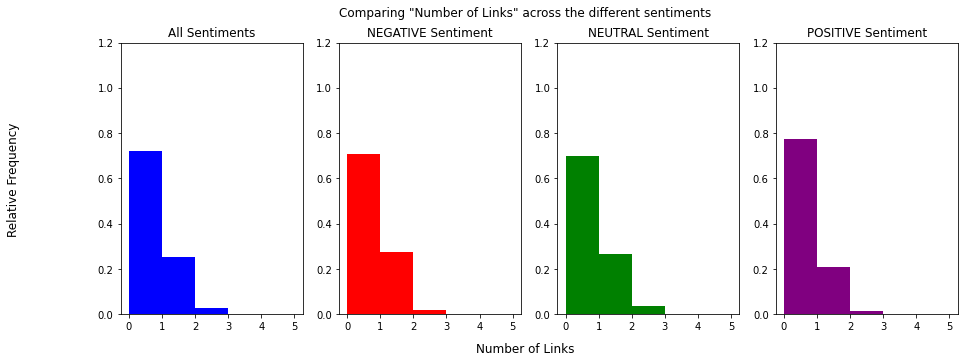

In [498]:
# Create a list of number of redirects/links
links = []
num_links = []

for t in tweets:
    ls = re.findall(r"https://t.co", t)
    num_links.append(len(ls))
    links.append(ls)
num_links = np.array(num_links)

# check the head and range of values for this
print(num_links[:10])
compare_histograms(num_links, label = "Number of Links")

### Hashtags
Hashtags are used in twitter to link tweets with similar subjects together.
Extracting these from the tweets may help in grouping similar tweets together.

[['#homeopathy'], [], [], [], [], ['#mtvstars'], ['#thisisus'], ['#orangetheworld', '#unitednations', '#unodc'], [], ['#nevereverquit']]


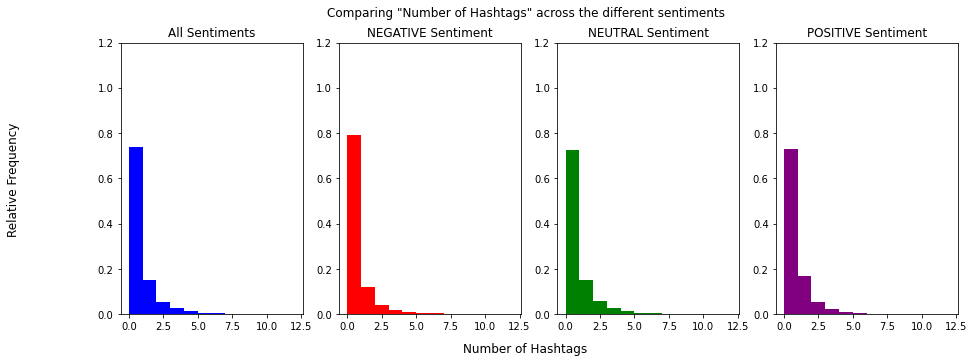

In [499]:
# create a list of hashtags in a tweet
hashtags = []
num_hashtags = []
set_hashtags = set()

for t in tweets:
    hashes = re.findall(r"#\w+", t)
    hashtags.append(hashes)
    num_hashtags.append(len(hashes))
    set_hashtags = set_hashtags.union(hashes)
num_hashtags = np.array(num_hashtags)

# check the head and range of values for this
print(hashtags[:10])
# print(set_hashtags)

compare_histograms(num_hashtags, label = "Number of Hashtags")

### User References
`@` symbols are used in twitter to reference a specific user.
Extracting these from the tweets may help in grouping tweets with similar recipients.

[[], [], [], ['@cbcnews'], [], [], ['@nbcthisisus'], [], [], []]
[0 0 0 1 0 0 1 0 0 0]


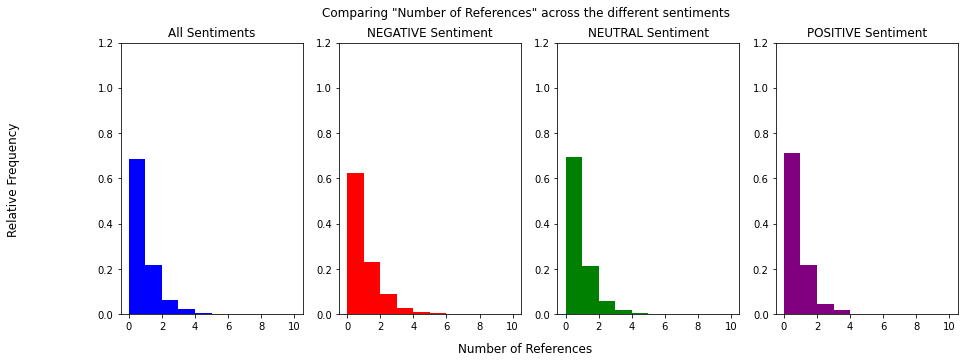

In [500]:
# create a list of user references in a tweet
references = []
num_references = []
set_references = set()

for t in tweets:
    refs = re.findall(r"@\w+", t)
    references.append(refs)
    num_references.append(len(refs))
    set_references = set_references.union(refs)
num_references = np.array(num_references)

# check the head and range of values for this
print(references[:10])
print(num_references[:10])
# print(set_references)

compare_histograms(num_references, label = "Number of References")


### Smiley Faces
`ASCII` emoji such as `:)`, `:(`, `:P` can indicate emotion, leading to potentially easier judgment on the sentiment of a tweet.

For the purposes of simplicity, emoji will be a combination of common eye symbols `;:B8=`, nose/middle symbols `',-"` and mouth symbols `LlPp|\/()[]VOo3`

[[], [':)'], [], [], [], [], [], [], [], []]
{':/', ':(', ':o', ';o', ':))', '=/', ':///', '(-8', '=))', ':-)', ':-o', '8)', ';-)', "(''':", ':-/', ':p', ':"")', '):', ':)', ':--(', '=)', ":'(", ':v', '(:', ':]', ';)', '=p', ':l', ':3', "(':", "((-':", ":')", '://'}
{':)', ':(', ':|', ':o'}


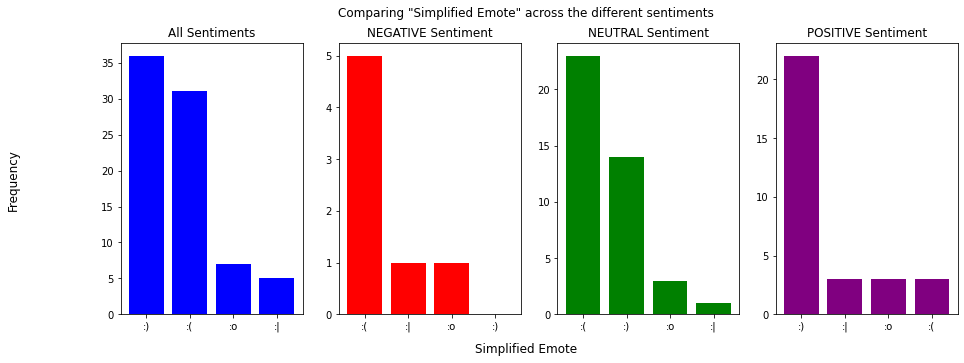

In [501]:
# create a list of hashtags in a tweet
emoticons = []
emoticons_simple = []
set_emoticons = set()
set_emoticons_simple = set()

# define the sets of symbols to construct the emoticons
re_eyes = r";:8="
re_middle = r"\',\-\"\*"
re_mouths_hap = r")3\]"
re_mouths_hap_backwards = r"(\["
re_mouths_sad = r"\\/(\["
re_mouths_sad_backwards = r")\]"
re_mouths_sur = r"vo"
re_mouths_neu = r"pl\|"
re_mouths = re_mouths_hap + re_mouths_sad + re_mouths_sur + re_mouths_neu
re_not_mouth = r"[" + re_eyes + r"]+[" + re_middle + r"]*"
# Only allow one type of mouth to be found at a time (`:\3` is not allowed)
re_search =  r"(?<=[ ^])[" + re_eyes + r"]+[" + re_middle + r"]*[" + re_mouths_hap + r"]+(?=[\W])|"
re_search += r"(?<=[ ^])[" + re_eyes + r"]+[" + re_middle + r"]*[" + re_mouths_sad + r"]+(?=[\W])|"
re_search += r"(?<=[ ^])[" + re_eyes + r"]+[" + re_middle + r"]*[" + re_mouths_sur + r"]+(?=[\W])|"
re_search += r"(?<=[ ^])[" + re_eyes + r"]+[" + re_middle + r"]*[" + re_mouths_neu + r"]+(?=[\W])|"
# add the backwards results
re_search += r"(?<=[ ^])[" + re_mouths_hap_backwards + r"]+[" + re_middle + r"]*[" + re_eyes + r"]+(?=[\W])|"
re_search += r"(?<=[ ^])[" + re_mouths_sad_backwards + r"]+[" + re_middle + r"]*[" + re_eyes + r"]+(?=[\W])"


# Simplifies emoticons to remove middle symbols and simplify eyes 
# (since it's really the mouth that gives emotion away)
def simplify_emoticon(emote):
    DEFAULT_EYES = ":"
    DEFAULT_NOSE = ""
    DEFAULT_MOUTH_HAP = ")"
    DEFAULT_MOUTH_SAD = "("
    DEFAULT_MOUTH_SUR = "o"
    DEFAULT_MOUTH_NEU = "|"

    # reverse it if needed
    if emote[0] in re_mouths_hap_backwards:
        emote = emote[::-1]
        emote = re.sub(r"[" + re_mouths_hap_backwards + r"]+", ")", emote)
    elif emote[0] in re_mouths_sad_backwards:
        emote = emote[::-1]
        emote = re.sub(r"[" + re_mouths_sad_backwards + r"]+", "(", emote)

    # shrink the emote to one of the simple :) :( :| :o emotes.
    e_simple = ""
    for symbol in emote:
        if symbol in re_eyes:
            symbol = DEFAULT_EYES
        elif symbol in re_middle: 
            symbol = DEFAULT_NOSE
        elif symbol in re_mouths_hap:
            symbol = DEFAULT_MOUTH_HAP
        elif symbol in re_mouths_sad:
            symbol = DEFAULT_MOUTH_SAD
        elif symbol in re_mouths_sur:
            symbol = DEFAULT_MOUTH_SUR
        elif symbol in re_mouths_neu:
            symbol = DEFAULT_MOUTH_NEU
        if len(e_simple) > 0:
            if symbol == e_simple[-1]: continue
            if symbol in re_mouths and e_simple[-1] in re_mouths:
                continue
        e_simple += symbol

    return e_simple

# iterate through tweets and extract the emoticons
for t in tweets:
    # extract the emotes
    emotes = re.findall(re_search, t)
    def isvalid(e): # remove purely alphanumeric emotes
        return not (e.isalnum() or e.isdecimal())
    emotes = list(filter(isvalid, emotes))
    emoticons.append(emotes)
    
    emotes_simple = []
    for e in emotes:
        if not e.isdigit():
            emotes_simple.append(simplify_emoticon(e))
    emoticons_simple.append(emotes_simple)

    set_emoticons = set_emoticons.union(emotes)
    set_emoticons_simple = set_emoticons_simple.union(emotes_simple)

# check the head and range of values for this
print(emoticons_simple[:10])
print(set_emoticons)
print(set_emoticons_simple)

# count occurrences of simple emoticons in each tweet
dict_emoticons_simple = dict()
list_emoticons_simple = list(set_emoticons_simple)

for emote in list_emoticons_simple:
    dict_emoticons_simple[emote] = []

# iterate through the simplified emoticon lists and count the occurrences of each
for emote_list in emoticons_simple:
    emote_counts = Counter(emote_list)
    for emote in list_emoticons_simple:
        dict_emoticons_simple[emote].append(emote_counts[emote])

# convert the occurrences to numpy arrays for easy indexing
for emote in list_emoticons_simple:
    dict_emoticons_simple[emote] = np.array(dict_emoticons_simple[emote])

compare_bar_graphs(dict_emoticons_simple, label = "Simplified Emote")


### Quoting

If a Tweet is quoting an article or another person, it may indicate a certain sentiment.

[False, False, False, True, False, False, False, False, True, False]


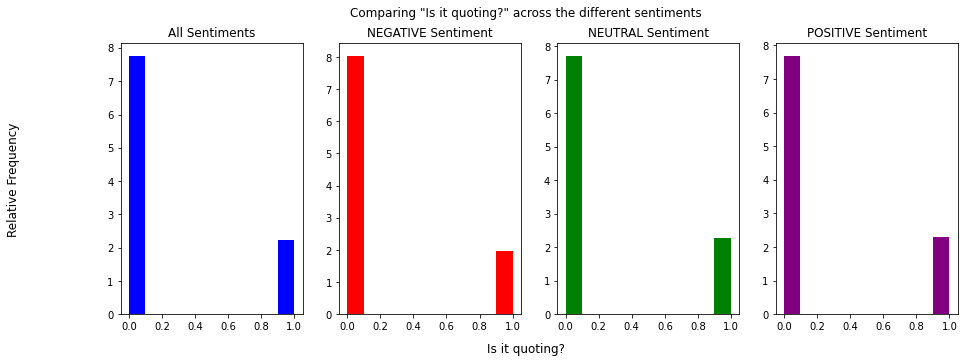

In [502]:
# define the list of binary is_quoting variables
is_quoting = [re.search(r"\"", x) is not None for x in tweets]
print(is_quoting[:10])
int_is_quoting = [1 if iq else 0 for iq in is_quoting]
int_is_quoting = np.array(int_is_quoting)

compare_histograms(int_is_quoting, "Is it quoting?", False)

### Phonetics

Extracting the phones for a word (phonetic pronunciation breakdown).

In [ ]:
# TODO: this

### Sibilance, Fricatives and Plosives. (Poetic Phonetics)

In the english language there are phonetic sounds which can have certain purpose when used in poetry. 
- **Plosives** describes `b`, `p`, `d`, `t`, `k`, `g` sounds which are used for an abrupt or sharp effect.
- **Hard Fricatives** describes hard `v`, `f`, `th` sounds which are used to convey a hard *vexed* effect.
- **Soft Fricatives** describes soft `f`, `th`, `ph` sounds which can be more relaxed and airy.
- **Sibilance** descibes `s`, `z`, `sh`, `ch`, `x` can be used *softly* or for *sinister* effect,

These effects are obviously heavily depended on the language of the tweets and may not actually mean anything in day-to-day use. This is just an interesting exploration of how they might correlate to the sentiments of the tweets.

[ 7. 10.  2. ...  3.  4.  8.]


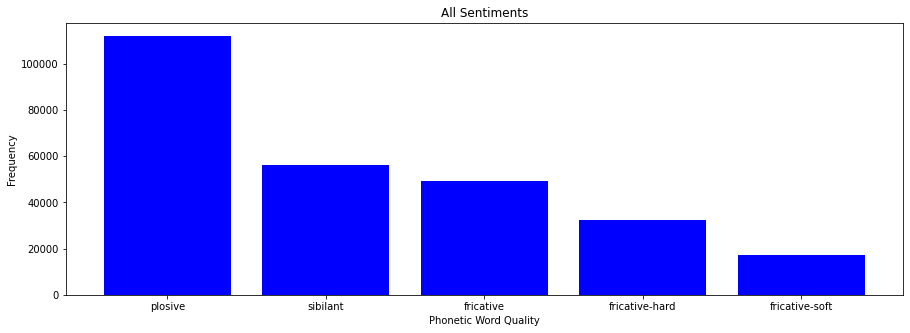

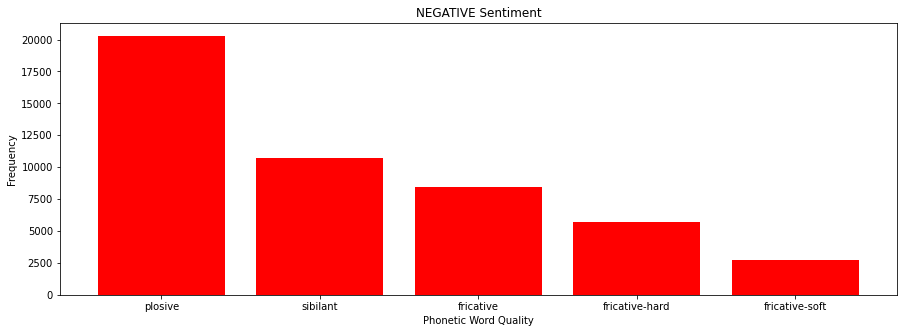

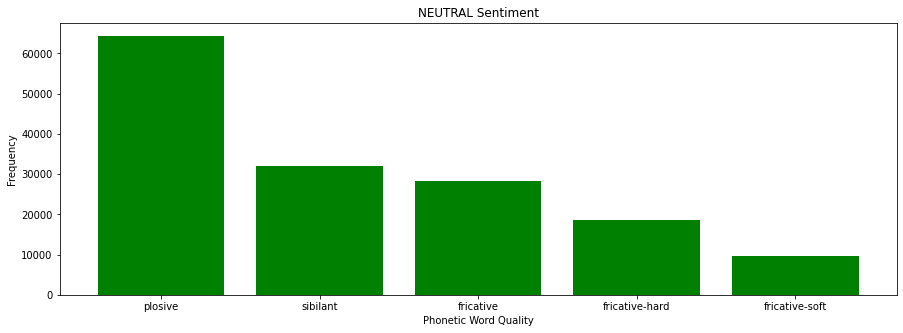

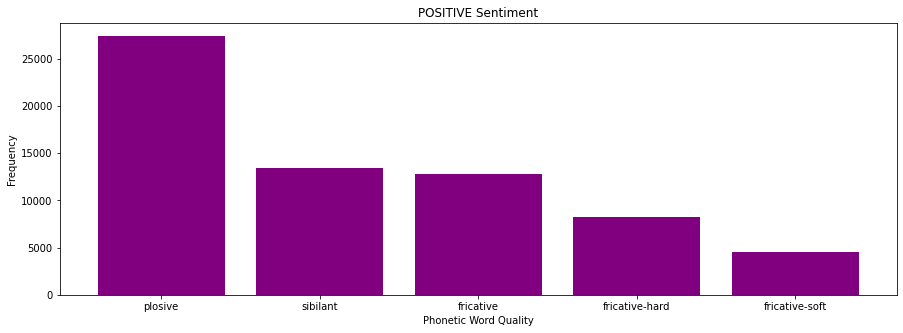

In [503]:
# create a list of hashtags in a tweet
poetics = defaultdict(zero_arr)

# sets of poetic noises
# using: https://nlp.stanford.edu/courses/lsa352/arpabet.html 
plosive_set = ['B', 'P', 'D', 'T', 'G', 'K', 'BCL', 'PCL', 'DCL', 'TCL', 'GCL', 'KCL', 'DX']
re_plosive = r"(?<=[ ^])" + r"(?=[ $])|(?<=[ ^])".join(plosive_set) + r"(?=[ $])"

fricative_hard_set = ['DH', 'V']
re_fricative_hard = r"(?<=[ ^])" + r"(?=[ $])|(?<=[ ^])".join(fricative_hard_set) + r"(?=[ $])"

fricative_soft_set = ['TH', 'F']
re_fricative_soft = r"(?<=[ ^])" + r"(?=[ $])|(?<=[ ^])".join(fricative_soft_set) + r"(?=[ $])"

sibilant_set = ['Z', 'S', 'CH', 'SH', 'ZH']
re_sibilant = r"(?<=[ ^])" + r"(?=[ $])|(?<=[ ^])".join(sibilant_set) + r"(?=[ $])"


# https://pronouncing.readthedocs.io/en/latest/pronouncing.html 
for idx, words in enumerate(tweet_word_lists):
    for w in words:
        phones = " ".join(pnc.phones_for_word(w))
        if re.search(re_plosive, phones) is not None:
            poetics["plosive"][idx] += 1
        
        if re.search(re_fricative_hard, phones) is not None:
            poetics["fricative-hard"][idx] += 1
            poetics["fricative"][idx] += 1

        if re.search(re_fricative_soft, phones) is not None:
            poetics["fricative-soft"][idx] += 1
            poetics["fricative"][idx] += 1

        if re.search(re_sibilant, phones) is not None:
            poetics["sibilant"][idx] += 1

print(poetics["plosive"])
compare_bar_graphs(poetics, label = "Poetic Word Quality", separate=True)

